# Analyse de survie multivariée, analyse de corrélation :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

### Analyse de survie multivariée :

Fonction de création du GEC : make_GEC

In [2]:
# genes retenus comme candidats pour le gec
biomarqueur = ['SPCS2P4','RNASE2','ESM1','HYAL3','HOMER1','CABLES2','MAGEA6']

def make_GEC(data, gene_biomarqueur, seuil_ectopy):
    """
    data :  expression data
    gene_biomarqueur : panel GEC des huit gènes candidats
    seuil_ectopy : thresholds calculated by "ectopy"
    """
   
    tab_GEC = {
        'id_sample': [],
        'SPCS2P4': [],
        'RNASE2': [],
        'ESM1': [],
        'HYAL3': [],
        'HOMER1': [],
        'CABLES2': [],
        'MAGEA6': [],
        'Gec': []
    }

    for i in range(1, data.shape[1]):
        id_sample = data.columns[i]
        tab_GEC['id_sample'].append(id_sample)
        num_active_genes = 0

        for gene in gene_biomarqueur:
            seuil = seuil_ectopy.loc[seuil_ectopy['Gene'] == gene, 'threshold_percentile'].values[0] / 100
            quantile_value = np.quantile(data.loc[data['gene_symbol'] == gene].iloc[:, 1:], seuil)
            gene_value = data.loc[data['gene_symbol'] == gene].iloc[:, i].astype(float)
            x = (gene_value > quantile_value).astype(int).values[0]
            num_active_genes += x
            tab_GEC[gene].append(x)
        
        tab_GEC['Gec'].append(num_active_genes)
        
    tab_GEC_df = pd.DataFrame(tab_GEC)

    return tab_GEC_df

Seuils caluclés par "ectopy" :

In [3]:
# import data(ectopy_adaptaive_threshold_percentile)

seuil_ectopy = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/TRAINING_Ectopy_python_significant_genes_TCGA-LIHC_FDR_1.0.xlsx")
#seuil_ectopy = seuil_ectopy.iloc[1:].reset_index(drop=True)
print(seuil_ectopy.shape)
seuil_ectopy.head(3)

(58, 10)


,Gene,threshold_name,threshold,threshold_percentile,p_value,hazard_ratio,validated,cv_score,optimal,FDR
0,APLN,T63,1.431588,51.107239,0.003155,1.704304,True,14,True,0.011771
1,ASIC1,T26,0.482416,66.923592,0.023705,1.513679,True,2,True,0.051098
2,ATP6V1E2,T109,0.847760,74.107239,0.004508,1.715253,True,14,True,0.013664


TCGA-LIHC dataset : 

In [2]:
# import data 

# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés
specific_gene = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

# expression data
expression_data_TCGA_LIHC = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans 109 gènes 
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'].isin(specific_gene[0].values)]

# clinic data
clinic_data_TCGA_LIHC = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_TCGA-LIHC.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.dropna(subset=['os_months', 'os_censor'])

# Sélection des échantillons tumoraux
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC[clinic_data_TCGA_LIHC['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_TCGA_LIHC['id_sample'].unique() if col in expression_data_TCGA_LIHC.columns]

# Sélection des données
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[['gene_symbol'] + selected_sample]

# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_TCGA_LIHC.columns[expression_data_TCGA_LIHC.isna().any()].tolist()

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.dropna(axis=1) 
expression_data_TCGA_LIHC.head()

,gene_symbol,TCGA-G3-A3CG-01A,TCGA-DD-AAVP-01A,TCGA-FV-A3R3-01A,TCGA-G3-A25Y-01A,TCGA-DD-AADU-01A,TCGA-BC-A10S-01A,TCGA-5R-AA1D-01A,TCGA-G3-A25Z-01A,TCGA-DD-AAEH-01A,...,TCGA-DD-AAE0-01A,TCGA-FV-A4ZP-01A,TCGA-DD-A39V-01A,TCGA-DD-AAEK-01A,TCGA-DD-AAVX-01A,TCGA-DD-A11A-01A,TCGA-ZP-A9CY-01A,TCGA-BC-A10R-01A,TCGA-QA-A7B7-01A,TCGA-CC-5264-01A
34,ASIC1,0.174279,3.806107,0.310805,0.730488,1.120949,0.029418,0.250598,0.019204,0.066537,...,0.831796,0.287945,1.615605,0.888071,0.051720,0.021338,0.069702,0.212134,0.035765,1.227864
270,AQP8,1.879078,5.055048,0.398460,0.062398,0.384271,1.625645,0.703721,2.199657,2.869082,...,0.056445,0.184217,0.254594,0.624896,0.035905,2.449112,3.076371,3.454847,0.142479,3.492110
1241,CYP27B1,0.138421,1.955350,0.057831,0.324350,0.246347,0.306846,0.205017,0.059771,0.032101,...,0.590051,0.364797,0.134615,0.242694,0.145743,0.150040,0.282499,0.088413,0.572502,0.785592
1390,SLC26A3,0.328607,1.705226,3.584024,1.322332,0.314290,0.028569,3.823953,0.032524,0.120883,...,0.023468,0.110764,0.022616,0.366252,0.072586,0.028993,0.051024,0.142479,0.060186,0.425567
1407,DSG1,0.609944,0.684908,0.218347,0.038296,2.524189,1.279174,0.054223,0.240620,1.410612,...,0.123931,0.010493,1.633478,2.044464,2.123037,1.126841,1.290483,1.914603,0.173255,0.129217


In [4]:
# id_sample en index dans clinic_data_TCGA_LIHC
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.set_index('id_sample') 

# dans clinic_data_TCGA_LIHC, on suprrime les id_sample(ligne complète) qui ont des nan dans expression_data_TCGA_LIHC
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.drop(colonnes_avec_nan)

clinic_data_TCGA_LIHC.shape

(373, 41)

In [5]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.reset_index() 

In [8]:
# appel de la fonction make_GEC pour le dataset TCGA_LIHC

data_gec_TCGA_LIHC = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
data_gec_TCGA_LIHC.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,TCGA-G3-A3CG-01A,1,0,0,0,0,0,0,1
1,TCGA-DD-AAVP-01A,0,1,1,1,0,1,0,4
2,TCGA-FV-A3R3-01A,0,0,0,0,0,0,0,0
3,TCGA-G3-A25Y-01A,1,1,0,1,0,1,0,4
4,TCGA-DD-AADU-01A,0,0,1,1,0,0,0,2


Modele de survie multivariée : dataset TCGA_LIHC

In [11]:
# modele de survie multivariée dans le dataset TCGA_LIHC

# données du gec
data_gec = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
gec = data_gec['Gec'].astype(float)

# Préparation des données pour le modèle de Cox

# Données de survie
time = clinic_data_TCGA_LIHC['os_months'].astype(float)  # temps
event = clinic_data_TCGA_LIHC['os_censor'].astype(float) # censure

age = clinic_data_TCGA_LIHC['age_min'].astype(float)             # âges des patients
sex = clinic_data_TCGA_LIHC['sex'].map({'F' : 0, 'M':1})         # sexes des patients

# stade de cancer
stage = clinic_data_TCGA_LIHC['tnm_stage'].map({'I' : 1, 'II' : 2, 'III' : 3, 'IIIA' : 3, 
                                                'IIIB' : 3, 'IIIC' : 3, 'IV' : 4, 'IVA' : 4, 'IVB' : 4})



# Création du DataFrame pour l'analyse de Cox

# Fusion des données nécessaires
data = pd.DataFrame({'duration': time, 
                     'event': event, 
                     'age': age,
                    'Gec': gec,
                    'sex': sex,
                    'stade': stage})

data = data.dropna() # suppression des données manquantes dites NaN

# Appliquer le modèle de Cox
cph = CoxPHFitter() # initialisation du modele

# Exécution du modele
cph.fit(data, duration_col='duration', event_col='event') # formula="Gec + age"
res = cph.summary  # résumé

data_pvalue = pd.DataFrame( res['p'])  # covariables et p_valeurs

# Afficher les résultats (covariables et p_valeurs)
data_pvalue

,p
covariate,
age,0.190808
Gec,0.000002
sex,0.877476
stade,0.000033


Autre façon de faire l'analyse de survie multivariée :

In [12]:
# modele de survie multivariée dans le dataset TCGA-LIHC

# données du gec
data_gec = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
gec = data_gec['Gec'].astype(float)


clinic_data = clinic_data_TCGA_LIHC.set_index('id_sample')  
data_gec = data_gec.set_index('id_sample')

# Préparer les données pour le modèle de Cox

# Données de survie
time = clinic_data['os_months'].astype(float)  # temps
event = clinic_data['os_censor'].astype(float) # censure

age = clinic_data['age_min'].astype(float)             # âges des patients
sex = clinic_data['sex'].map({'F' : 0, 'M':1})         # sexes des patients

# stade de cancer
stage = clinic_data['tnm_stage'].map({'I' : 1, 'II' : 2, 'III' : 3, 'IIIA' : 3, 
                                                'IIIB' : 3, 'IIIC' : 3, 'IV' : 4, 'IVA' : 4, 'IVB' : 4})




# Ajustement du modèle de Cox
cph = CoxPHFitter()

data_surv = data_gec[['Gec']].copy()
data_surv['time'] = time
data_surv['event'] = event
data_surv['age_min'] = age
data_surv['sex'] = sex
data_surv['tnm_stage'] = stage

#data_surv = data_surv[['time', 'event', 'Gec' ]].copy()

data_surv = data_surv.dropna()

cph.fit(data_surv, duration_col='time', event_col='event')
res = cph.summary  # résumé

data_pvalue = pd.DataFrame(res['p'])  # covariables et p_valeurs

# Afficher les résultats (covariables et p_valeurs)
data_pvalue

,p
covariate,
Gec,0.000002
age_min,0.190808
sex,0.877476
tnm_stage,0.000033


GSE144269 dataset :

In [15]:
# import data 

# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés
specific_gene = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

# expression data
expression_data_GSE144269 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE144269_log_rpkm_140_samples_31263_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans 109 gènes 
expression_data_GSE144269 = expression_data_GSE144269[expression_data_GSE144269['gene_symbol'].isin(specific_gene[0].values)]

# clinic data
clinic_data_GSE144269 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_GSE144269.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [16]:
clinic_data_GSE144269 = clinic_data_GSE144269.dropna(subset=['os_months', 'os_censor'])

# Sélection des échantillons tumoraux
clinic_data_GSE144269 = clinic_data_GSE144269[clinic_data_GSE144269['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE144269['id_sample'].unique() if col in expression_data_GSE144269.columns]

# Sélection des données
expression_data_GSE144269 = expression_data_GSE144269[['gene_symbol'] + selected_sample]

expression_data_GSE144269.shape

(109, 71)

Modele de survie multivariée : dataset GSE144269

In [17]:
# modele de survie multivariée dans le dataset GSE144269

# Données du gec
data_gec = make_GEC(expression_data_GSE144269, biomarqueur, seuil_ectopy)
gec = data_gec['Gec'].astype(float)


clinic_data = clinic_data_GSE144269.set_index('id_sample')  
data_gec = data_gec.set_index('id_sample')

# Préparer les données pour le modèle de Cox

# Données de survie
time = clinic_data['os_months'].astype(float)              # temps
censure = clinic_data['os_censor'].astype(float)           # censure

age = clinic_data['age_min'].astype(float)                 # âges des patients

#sex = clinic_data_GSE144269['sex'].map({'F' : 0, 'M':1})  # le dataset GSE144269 ne contient pas le sexe des patients

stage = clinic_data['tnm_stage']                           # stades de cancer
  
    
# Création du DataFrame pour l'analyse de Cox
data_surv = data_gec[['Gec']].copy()
data_surv['time'] = time
data_surv['event'] = censure
data_surv['age_min'] = age
data_surv['tnm_stage'] = stage

# data_surv = data_surv[['time', 'event', 'Gec' ]].copy()

data_surv = data_surv.dropna()

# Ajustement du modèle de Cox
cph = CoxPHFitter()

cph.fit(data_surv, duration_col='time', event_col='event')
res = cph.summary  # résumé

data_pvalue = pd.DataFrame(res['p'])  # covariables et p_valeurs

# Afficher les résultats (covariables et p_valeurs)
data_pvalue

,p
covariate,
Gec,0.049714
age_min,0.623443
tnm_stage,0.028365


GSE76427 dataset : 

In [4]:
# dataset "GSE76427" 

expression_data_GSE76427 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE76427_GSE76427_log_expression_167_samples_30499_genes.csv", sep=";")

# clinic data
clinic_data_GSE76427 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.04.03_GSE76427.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
expression_data_GSE76427.head()

,id_gene,gene_symbol,GSM2011285,GSM2011286,GSM2011287,GSM2011288,GSM2011289,GSM2011290,GSM2011291,GSM2011292,...,GSM2011442,GSM2011443,GSM2011444,GSM2011445,GSM2011446,GSM2011447,GSM2011448,GSM2011449,GSM2011450,GSM2011451
0,1,A1BG,6.619120,7.011004,7.545196,7.019924,6.719183,7.523719,6.759555,6.758223,...,7.710531,7.725605,7.276124,7.228723,7.148426,6.765800,7.316327,6.853621,7.500244,6.899055
1,2,A2M,12.365713,13.697642,13.794450,12.895821,11.875580,13.523074,12.978240,12.354175,...,13.479346,13.240466,13.562326,14.008014,14.540282,13.396336,13.777878,13.939963,13.314478,13.884958
2,9,NAT1,6.989366,7.357904,7.188539,7.557425,7.476463,7.157650,7.214805,7.136684,...,7.923803,7.369205,7.504382,7.216746,7.034194,7.048105,7.541484,7.924634,7.602959,7.369903
3,10,NAT2,8.555663,8.562357,9.078071,9.307884,9.191553,8.590886,9.011898,8.550131,...,10.637005,10.495036,10.969530,10.881695,10.784668,9.466240,11.649270,11.216509,10.959205,11.435696
4,12,SERPINA3,14.692071,14.649701,14.995486,14.871793,13.604289,14.212165,15.059422,14.735338,...,14.123203,14.975169,15.069273,15.230917,15.090151,15.189486,14.575714,14.151304,14.766150,14.900514


In [36]:
clinic_data_GSE76427.head()

,id_sample,main_gse_number,id_platform,organism,sample_title,sample_source,sex,ethnic_group,age_min,age_max,...,tnm_stage,tnm_grade,dfs_months,os_months,relapsed,dead,treatment,exposure,os_censor,dfs_censor
0,GSM2011285,GSE76427,GPL10558,Homo sapiens,"Primary HCC tumor tissue, 19",hepatocellular carcinoma tumor tissue,M,NaN,55.0,55.0,...,NaN,NaN,18.96,30.72,True,False,NaN,NaN,0.0,1.0
1,GSM2011286,GSE76427,GPL10558,Homo sapiens,"Primary HCC tumor tissue, 62",hepatocellular carcinoma tumor tissue,M,NaN,70.0,70.0,...,NaN,NaN,13.80,26.04,True,False,NaN,NaN,0.0,1.0
2,GSM2011287,GSE76427,GPL10558,Homo sapiens,"Primary HCC tumor tissue, 21",hepatocellular carcinoma tumor tissue,M,NaN,65.0,65.0,...,NaN,NaN,0.48,0.48,False,False,NaN,NaN,0.0,0.0
3,GSM2011288,GSE76427,GPL10558,Homo sapiens,"Primary HCC tumor tissue, 63",hepatocellular carcinoma tumor tissue,M,NaN,77.0,77.0,...,NaN,NaN,5.28,5.88,True,True,NaN,NaN,1.0,1.0
4,GSM2011289,GSE76427,GPL10558,Homo sapiens,"Primary HCC tumor tissue, 46",hepatocellular carcinoma tumor tissue,M,NaN,55.0,55.0,...,NaN,NaN,11.40,11.76,True,True,NaN,NaN,1.0,1.0


In [6]:
clinic_data_GSE76427 = clinic_data_GSE76427.dropna(subset=['os_months', 'os_censor'])

# Sélection des échantillons tumoraux
clinic_data_GSE76427 = clinic_data_GSE76427[clinic_data_GSE76427['sample_source'] == "hepatocellular carcinoma tumor tissue"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE76427['id_sample'].unique() if col in expression_data_GSE76427.columns]

# Sélection des données
expression_data_GSE76427 = expression_data_GSE76427[['gene_symbol'] + selected_sample]

expression_data_GSE76427.shape

(30499, 116)

In [7]:
# GSE76427

data_gec_GSE76427 = make_GEC(expression_data_GSE76427, biomarqueur, seuil_ectopy)
data_gec_GSE76427.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM2011285,0,0,1,0,0,1,0,2
1,GSM2011286,0,0,0,1,0,0,1,2
2,GSM2011287,1,0,1,0,0,0,0,2
3,GSM2011288,0,0,0,1,0,0,1,2
4,GSM2011289,0,0,1,1,0,1,0,3


Modele de survie multivariée : dataset GSE76427

In [10]:
# modele de survie multivariée dans le dataset GSE76427

# Données du gec
data_gec = make_GEC(expression_data_GSE76427, biomarqueur, seuil_ectopy)

clinic_data = clinic_data_GSE76427.set_index('id_sample')  
data_gec = data_gec.set_index('id_sample')

# Préparer les données pour le modèle de Cox

# Données de survie
temps = clinic_data['os_months'].astype(float)       # temps
censure = clinic_data['os_censor'].astype(float)     # censure

age = clinic_data['age_min'].astype(float)           # âges des patients

sex = clinic_data['sex'].map({'F' : 0, 'M':1})       

#stage = clinic_data['tnm_stage']                    # le dataset GSE76427 ne contient pas les stades de cancer
  
# Données pour le modèle    
data_surv = data_gec[['Gec']].copy()
data_surv['time'] = temps
data_surv['event'] = censure
#data_surv['age_min'] = age
#data_surv['sex'] = sex

#data_surv = data_surv[['time', 'event', 'age_min', 'sex' ]].copy()

data_surv = data_surv.dropna()

# Ajustement du modèle de Cox
cph = CoxPHFitter()

cph.fit(data_surv, duration_col='time', event_col='event')
res = cph.summary  # résumé

data_pvalue = pd.DataFrame(res['p'])  # covariables et p_valeurs

# Afficher les résultats (covariables et p_valeurs)
data_pvalue

,p
covariate,
Gec,0.142788


GSE121248 dataset :

In [11]:
# dataset "GSE121248" 

expression_data_GSE121248 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE121248_GSE121248_log_expression_107_samples_21872_genes.csv", sep=";")

# clinic data
clinic_data_GSE121248 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_GSE121248.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
# Sélection des échantillons tumoraux
clinic_data_GSE121248 = clinic_data_GSE121248[clinic_data_GSE121248['sample_source'] == "Tumor sample from hepatocellular carcinoma patient"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE121248['id_sample'].unique() if col in expression_data_GSE121248.columns]

# Sélection des données
expression_data_GSE121248 = expression_data_GSE121248[['gene_symbol'] + selected_sample]

expression_data_GSE121248.head()

,gene_symbol,GSM3428733,GSM3428770,GSM3428750,GSM3428730,GSM3428747,GSM3428727,GSM3428773,GSM3428753,GSM3428779,...,GSM3428762,GSM3428725,GSM3428745,GSM3428731,GSM3428751,GSM3428777,GSM3428774,GSM3428771,GSM3428734,GSM3428754
0,A1BG,13.145079,13.118273,13.215534,13.051060,11.021534,12.559943,12.291622,12.783900,12.537117,...,13.247361,13.161577,13.261560,13.110879,11.751025,13.789668,12.521671,12.516226,8.795688,11.910646
1,A2M,13.342202,12.725662,12.553407,13.502483,13.179525,13.263872,12.601803,10.950926,13.375806,...,12.380873,12.399291,13.628400,13.536591,12.903227,11.899765,12.680831,12.912727,12.766574,12.136907
2,A2MP1,5.162114,4.591075,5.396270,5.508598,4.734823,4.866892,5.486729,5.129093,4.680912,...,4.776731,5.250591,5.103338,5.022283,4.981959,5.553155,4.970691,5.374989,5.163157,5.024710
3,NAT1,7.715894,7.378908,8.770110,8.879047,6.644994,6.958841,7.229197,7.402302,7.804111,...,6.497482,9.003516,8.154285,8.104136,7.632132,8.718640,7.081439,6.172693,5.549184,8.122492
4,NAT2,7.343084,6.512738,7.905968,10.525658,5.633086,6.105676,6.644936,8.636656,7.568277,...,5.823022,7.738990,5.846448,8.973612,8.182548,9.845588,6.369902,6.630015,5.913346,5.977975


In [13]:
# appel de la fonction make_gec pour le dataset GSE121248

data_gec_GSE121248 = make_GEC(expression_data_GSE121248, biomarqueur, seuil_ectopy)
data_gec_GSE121248.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM3428733,0,1,0,0,0,1,0,2
1,GSM3428770,0,0,0,1,1,0,0,2
2,GSM3428750,0,0,1,0,0,0,0,1
3,GSM3428730,0,0,0,0,0,0,0,0
4,GSM3428747,0,0,1,0,1,1,0,3



Modele de survie multivariée : dataset GSE121248

Le dataset GSE121248 ne contient pas de données de survie donc l'analyse de survie multivariée ne peut pas être réalisée. 



GSE141202 dataset : 

In [44]:
# expression data

expression_data_GSE141202 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE141202_log_rpkm_206_samples_38133_genes.csv", sep=";")

# clinic data
clinic_data_GSE141202 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.04.03_GSE141202.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [45]:
# Sélection des échantillons tumoraux
clinic_data_GSE141202 = clinic_data_GSE141202[clinic_data_GSE141202['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE141202['id_sample'].unique() if col in expression_data_GSE141202.columns]

# Sélection des données
expression_data_GSE141202 = expression_data_GSE141202[['gene_symbol'] + selected_sample]


Modele de survie multivariée : dataset GSE141202

In [49]:
# modele de survie multivariée dans le dataset GSE76427

# Données du gec
data_gec = make_GEC(expression_data_GSE141202, biomarqueur, seuil_ectopy)

clinic_data = clinic_data_GSE141202.set_index('id_sample')  
data_gec = data_gec.set_index('id_sample')

# Préparer les données pour le modèle de Cox

# Données de survie
temps = clinic_data['os_months'].astype(float)       # temps
censure = clinic_data['os_censor'].astype(float)     # censure

# age = clinic_data['age_min'].astype(float)         # le dataset GSE141202 ne contient pas l'âge des patients

# sex = clinic_data['sex'].map({'F' : 0, 'M':1})     # le dataset GSE141202 ne contient pas le sexe des patients  

#stage = clinic_data['tnm_stage']                    # le dataset GSE141202 ne contient pas les stades de cancer
  
# Données pour le modèle    
data_surv = data_gec[['Gec']].copy()
data_surv['time'] = temps
data_surv['event'] = censure

data_surv = data_surv.dropna()

# Ajustement du modèle de Cox
cph = CoxPHFitter()

cph.fit(data_surv, duration_col='time', event_col='event')
res = cph.summary  # résumé

data_pvalue = pd.DataFrame(res['p'])  # covariables et p_valeurs

# Afficher les résultats (covariables et p_valeurs)
data_pvalue

,p
covariate,
Gec,0.000038


### Analyse de corrélation des huit gènes du panel GEC : 

In [42]:
# fonction pour automatiser le processus d'analyse de corrélation pour tous les datasets

def gene_corr(expression_data, dataset_name, gec):
    
    """
    expression_data : données d'expression de gènes
    dataset_name : nom du dataset, utile pour le titre du graphe
    gec : les 8 gènes constituant le gec
    
    """
    
    # pour faciliter la récupération des données d'expression, gene_symbol en indice
    exp_data = expression_data.set_index('gene_symbol') 
    
    #----------------------------------------------------------------------------
    for i, gene_x in enumerate(gec):
        
        for j, gene_y in enumerate(gec):
            
            if i > j:   
                
                # expression data
                x = exp_data.loc[gene_x]
                y = exp_data.loc[gene_y]
                
                # Calcul du coefficient de corrélation
                c_pearson, p_pearson = pearsonr(x, y)
                
                # Création de la figure et des axes pour chaque paire de gènes
                fig, ax = plt.subplots()
                sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s': 50}, line_kws={'color': 'black'}, ci=None)
                
                # Ajouter les noms des gènes aux axes
                ax.set_xlabel(gene_x)
                ax.set_ylabel(gene_y)
                
                # Titre et annotations
                ax.set_title(f"{dataset_name} (n={len(x)})\nPearson correlation coefficient = {c_pearson:.2f}\np-value = {p_pearson:.1e}")
                
                # Afficher le graphe
                plt.show()

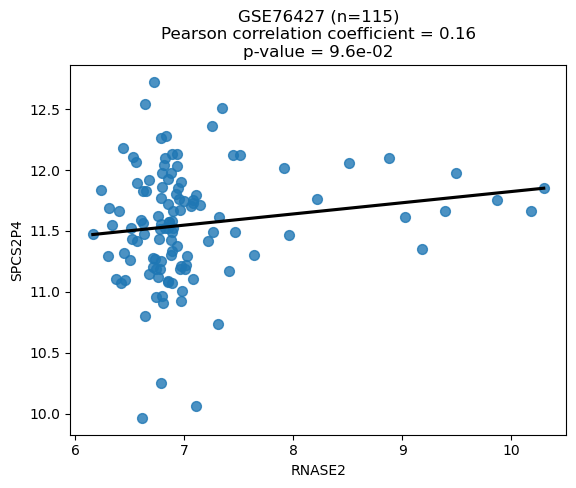

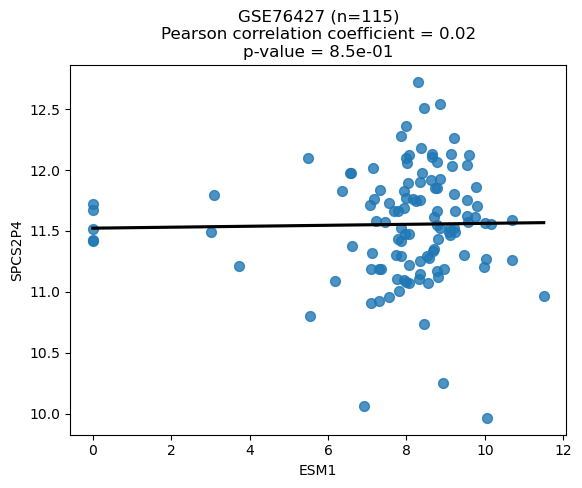

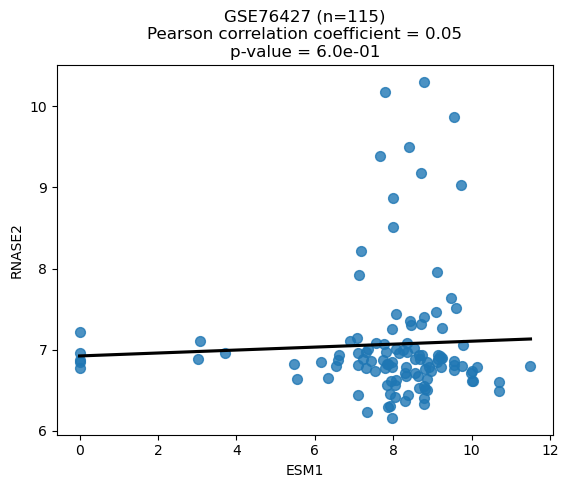

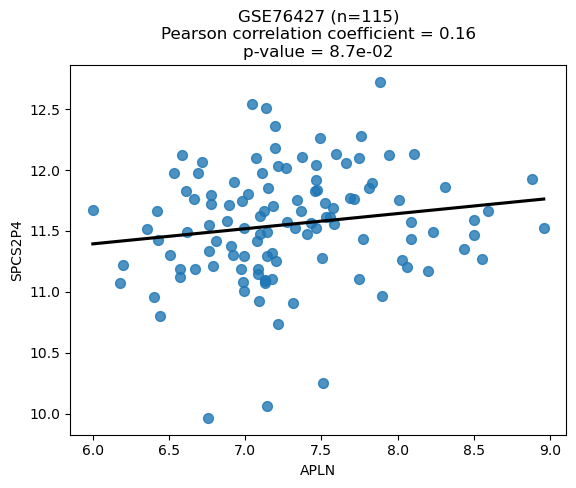

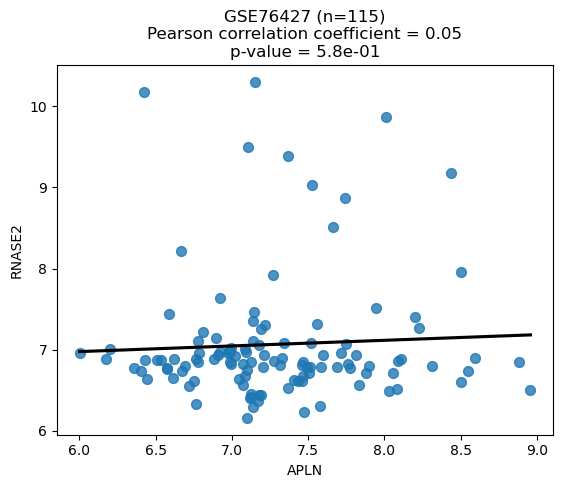

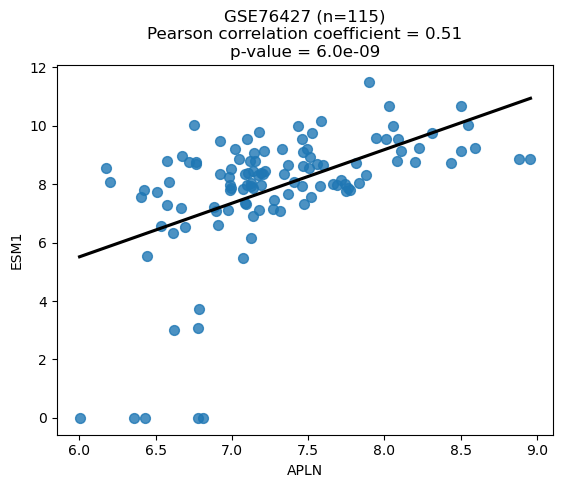

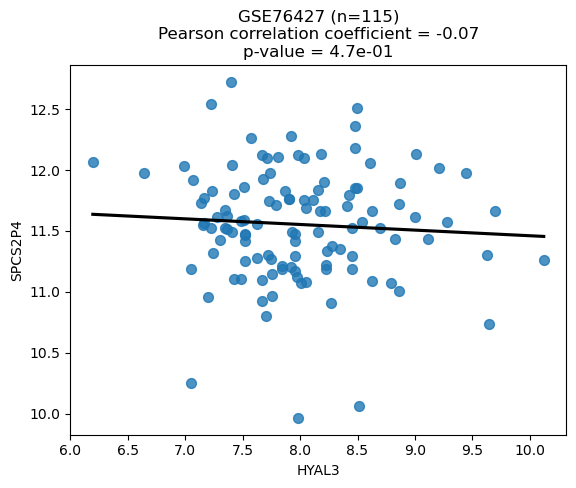

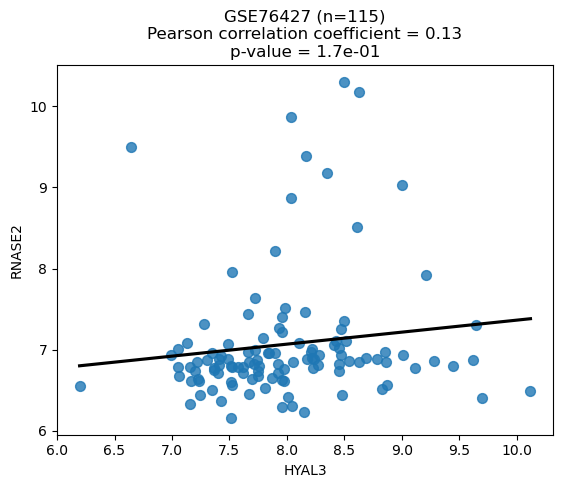

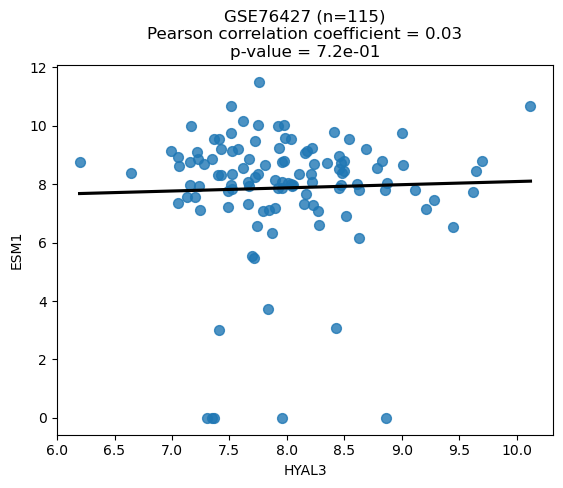

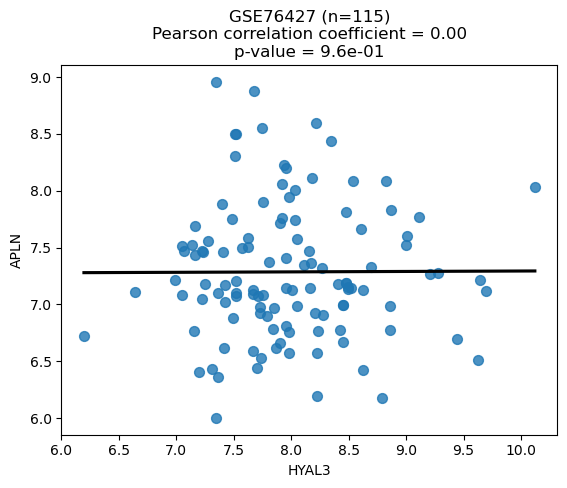

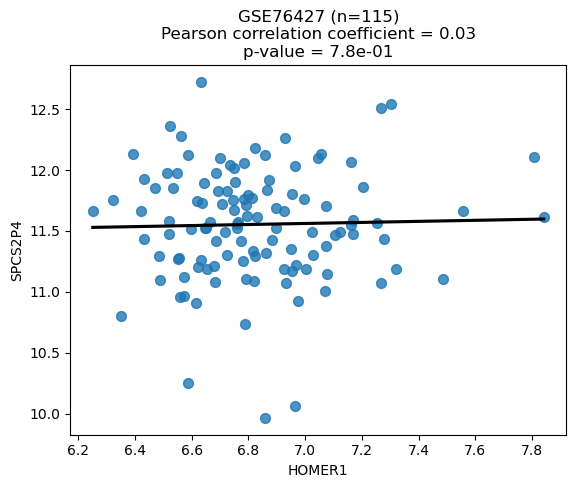

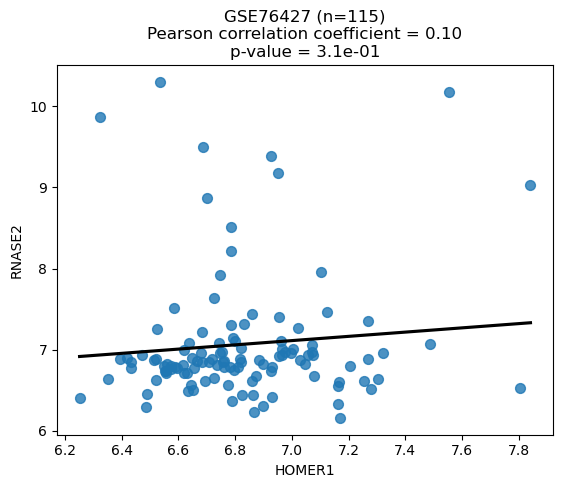

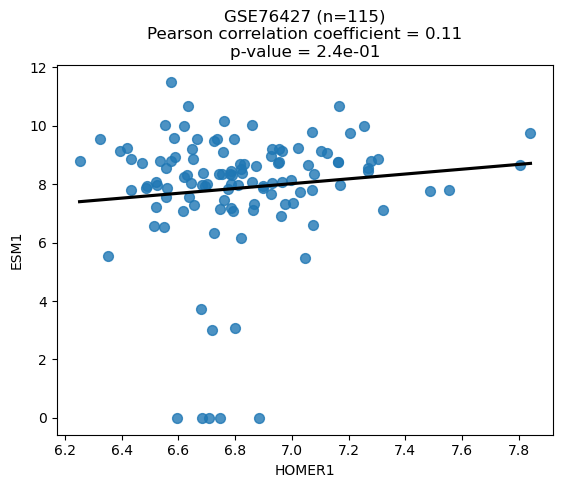

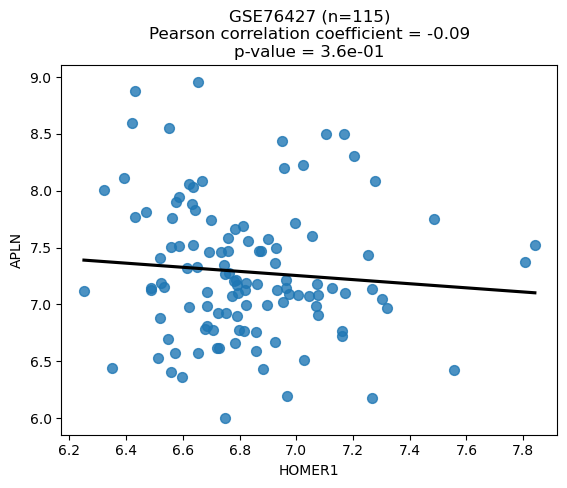

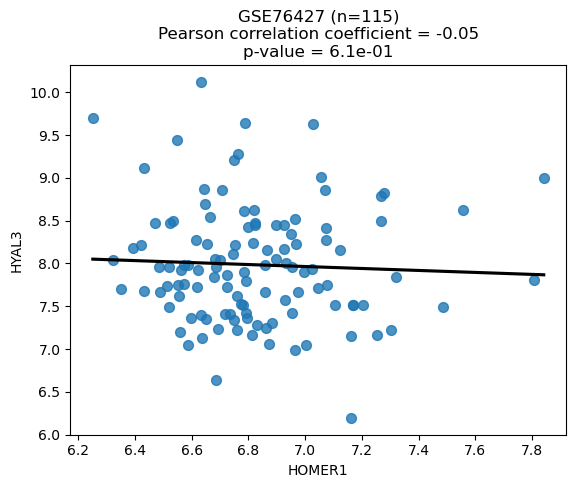

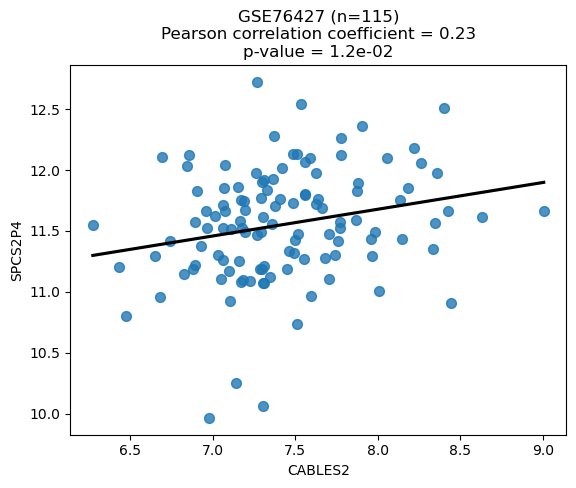

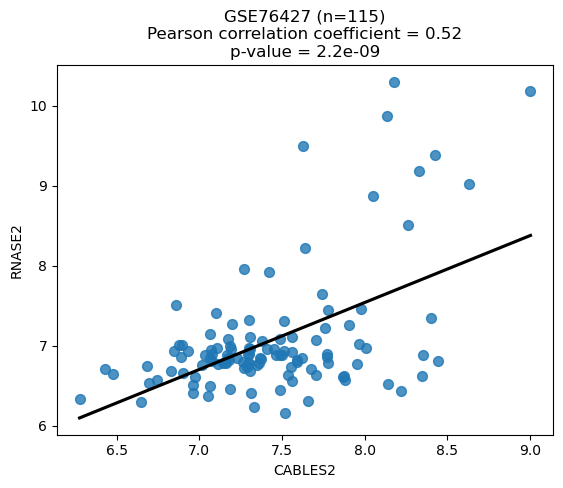

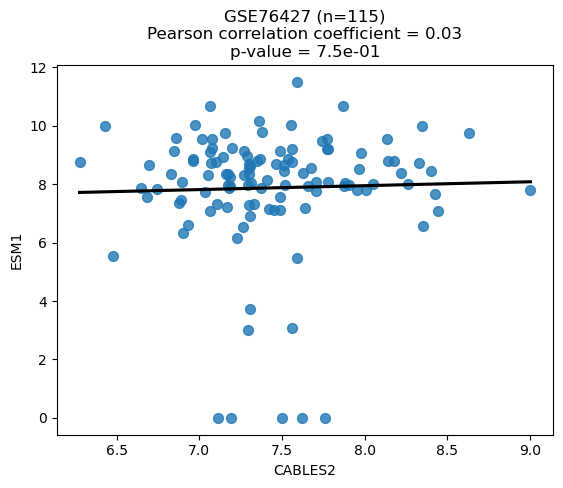

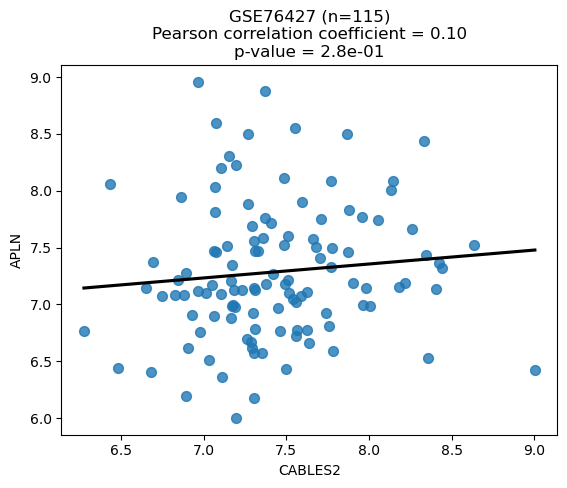

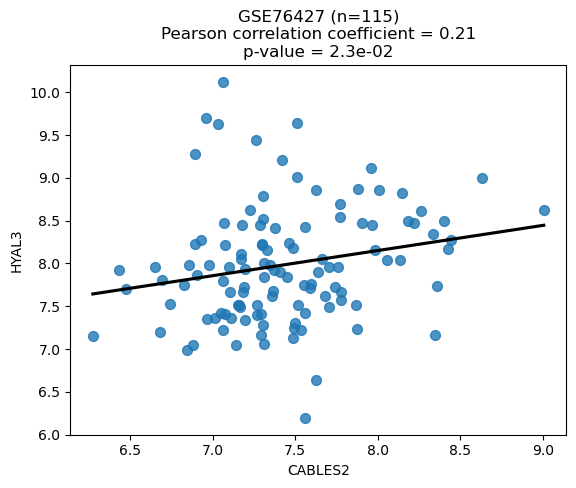

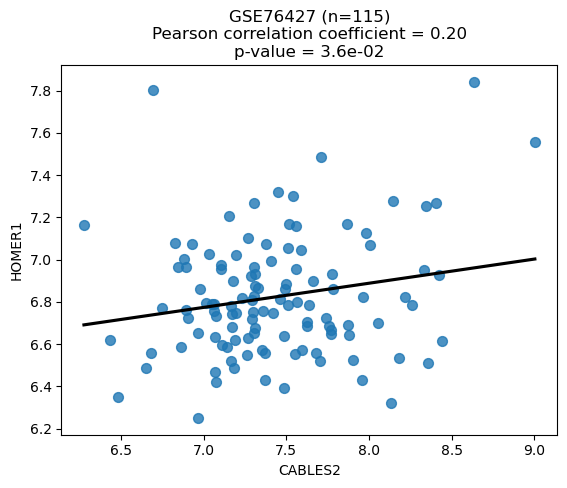

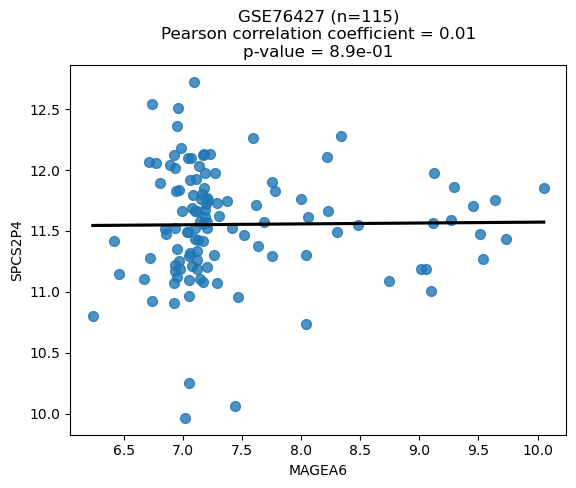

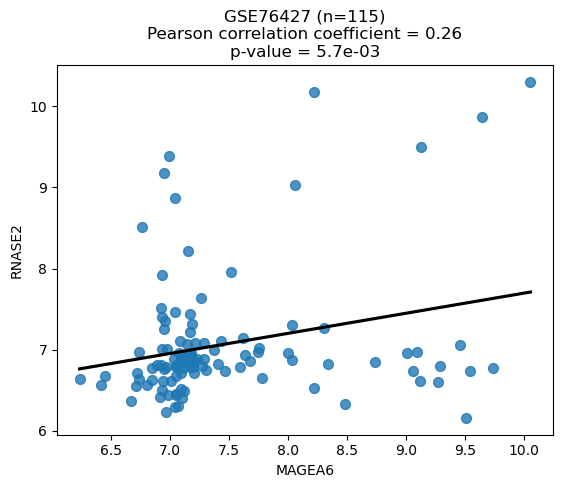

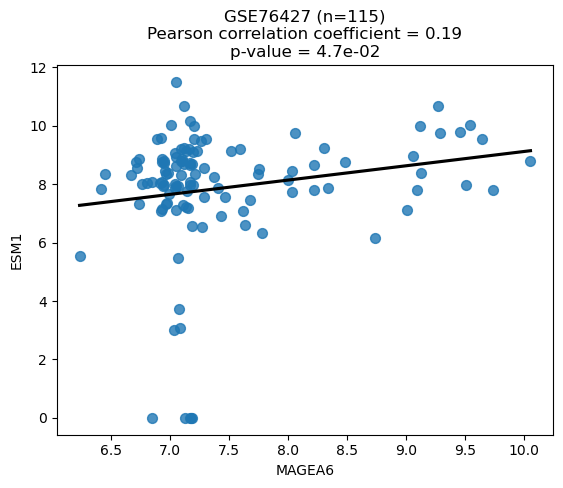

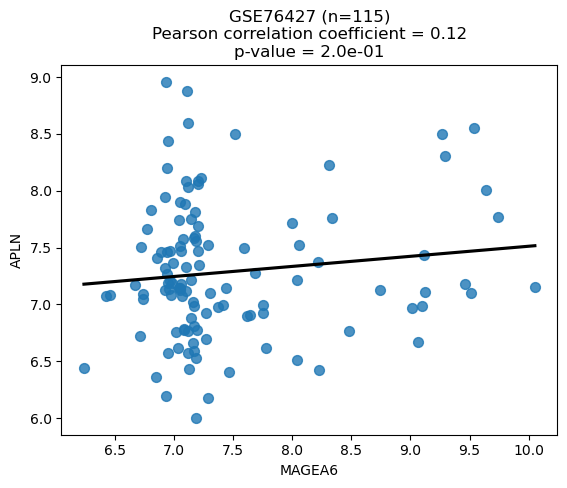

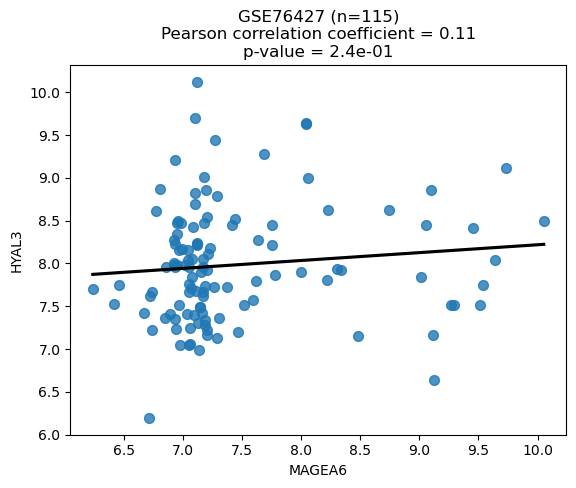

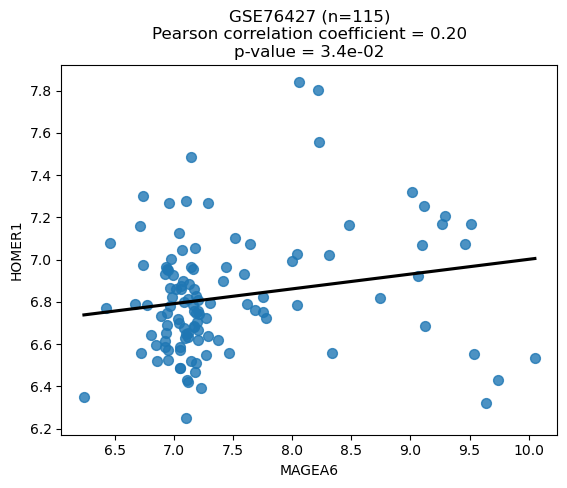

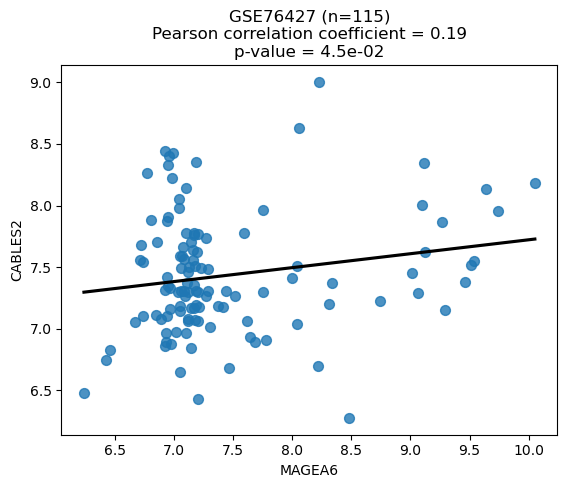

In [43]:
# exemple d'utilisation de la focntion gene_corr

# avec le dataset GSE76427

# genes retenus comme candidats pour le gec
biomarqueur = ['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6']

gene_corr(expression_data_GSE76427, "GSE76427", biomarqueur) 